In [9]:
import numpy as np
import torch
import torch.nn as nn
import torch.functional as F
import torch.utils.data as data_utils
import matplotlib.pyplot as plt
from torchdiffeq import odeint
from torchcontrol.arch_cpugpu import HDNN, HDNN_Observer
from torchcontrol.utils import genpoints

In [2]:
if torch.cuda.is_available(): device = torch.device('cuda')

In [3]:
class duffingOscillator(nn.Module):
    def __init__(self, n, w, beta, gamma):
        super().__init__()
        self.J = createJ(n, w, beta, gamma)
    def forward(self, t, xi):
        return torch.matmul(self.J,xi).to(device)

In [4]:
def createJ(n, w, beta, gamma):
    I = torch.eye(n//2)
    M1 = (-w*2-beta)*torch.eye(n//2)
    M2 = (-gamma)*torch.eye(n//2)
    O = torch.zeros((n//2,n//2))
    return torch.cat(((torch.cat((O,I),1)),(torch.cat((M1,M2),1))),0).to(device)

In [5]:
A = createJ(2,1,1,1)
B = createJ(2,1,1,1)
A, B

(tensor([[ 0.,  1.],
         [-3., -1.]], device='cuda:0'), tensor([[ 0.,  1.],
         [-3., -1.]], device='cuda:0'))

In [6]:
osc = duffingOscillator(2,0.5,0.5,0.2)
t = torch.linspace(0,25,100)
xi0 = torch.Tensor([1,0.5]).to(device)
func = osc.forward
sol = odeint(func,xi0,t)

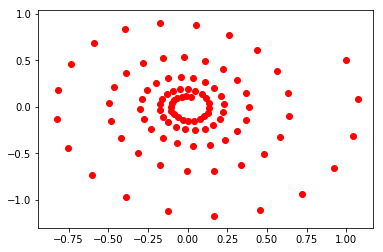

In [7]:
for p in range(len(sol)):
    plt.scatter(sol[p][0].cpu().numpy(),sol[p][1].cpu().numpy(), color='r')

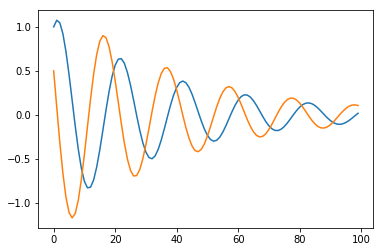

In [8]:
plt.plot(sol.cpu().numpy())

## Create dataset

In [9]:
osc = duffingOscillator(2,0.5,0.5,0.2)
t = torch.linspace(0,7,100)
xi0 = torch.Tensor([1,0.5]).to(device)
func = osc.forward
sol = odeint(func,xi0,t)

In [10]:
labels = sol[1:]

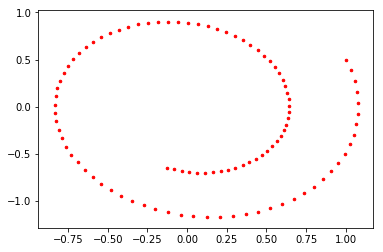

In [11]:
for p in range(len(sol)):
    plt.scatter(sol[p][0].cpu().numpy(),sol[p][1].cpu().numpy(), s=6.5, color='r')

## Learning a trajectory with HDDNs (access to full state, RNN test)

In [22]:
obs = HDNN_Observer([2,36,2],'MLP',[1,2,0],1, None, False, 'cpu')

In [23]:
x0 = torch.Tensor([1,0.5]).to(device)
x0 = x0.view(1,2)

In [24]:
t = obs.observe(x0, labels, epoch=1, ode_t=5, ode_step=2, loss_record_interval=100)

odeint iter: 10 
odeint iter: 20 
odeint iter: 30 
odeint iter: 40 
odeint iter: 50 
odeint iter: 60 
odeint iter: 70 
odeint iter: 80 
odeint iter: 90 
odeint iter: 100 
odeint iter: 110 
odeint iter: 120 
odeint iter: 130 
odeint iter: 140 
odeint iter: 150 
odeint iter: 160 
odeint iter: 170 
odeint iter: 180 
odeint iter: 190 
odeint iter: 200 
odeint iter: 210 
odeint iter: 220 
odeint iter: 230 
odeint iter: 240 
odeint iter: 250 
odeint iter: 260 
odeint iter: 270 
odeint iter: 280 
odeint iter: 290 
odeint iter: 300 
odeint iter: 310 
odeint iter: 320 
odeint iter: 330 
odeint iter: 340 
odeint iter: 350 
odeint iter: 360 
odeint iter: 370 
odeint iter: 380 
odeint iter: 390 
odeint iter: 400 
odeint iter: 410 
odeint iter: 420 
odeint iter: 430 
odeint iter: 440 
odeint iter: 450 
odeint iter: 460 
odeint iter: 470 
odeint iter: 480 
odeint iter: 490 
odeint iter: 500 
odeint iter: 510 
odeint iter: 520 
odeint iter: 530 
odeint iter: 540 
odeint iter: 550 
odeint iter: 560 
o

odeint iter: 4420 
odeint iter: 4430 
odeint iter: 4440 
odeint iter: 4450 
odeint iter: 4460 
odeint iter: 4470 
odeint iter: 4480 
odeint iter: 4490 
odeint iter: 4500 
odeint iter: 4510 
odeint iter: 4520 
odeint iter: 4530 
odeint iter: 4540 
odeint iter: 4550 
odeint iter: 4560 
odeint iter: 4570 
odeint iter: 4580 
odeint iter: 4590 
odeint iter: 4600 
odeint iter: 4610 
odeint iter: 4620 
odeint iter: 4630 
odeint iter: 4640 
odeint iter: 4650 
odeint iter: 4660 
odeint iter: 4670 
odeint iter: 4680 
odeint iter: 4690 
odeint iter: 4700 
odeint iter: 4710 
odeint iter: 4720 
odeint iter: 4730 
odeint iter: 4740 
odeint iter: 4750 
odeint iter: 4760 
odeint iter: 4770 
odeint iter: 4780 
odeint iter: 4790 
odeint iter: 4800 
odeint iter: 4810 
odeint iter: 4820 
odeint iter: 4830 
odeint iter: 4840 
odeint iter: 4850 
odeint iter: 4860 
odeint iter: 4870 
odeint iter: 4880 
odeint iter: 4890 
odeint iter: 4900 
odeint iter: 4910 
odeint iter: 4920 
odeint iter: 4930 
odeint iter:

odeint iter: 8770 
odeint iter: 8780 
odeint iter: 8790 
odeint iter: 8800 
odeint iter: 8810 
odeint iter: 8820 
odeint iter: 8830 
odeint iter: 8840 
odeint iter: 8850 
odeint iter: 8860 
odeint iter: 8870 
odeint iter: 8880 
odeint iter: 8890 
odeint iter: 8900 
odeint iter: 8910 
odeint iter: 8920 
odeint iter: 8930 
odeint iter: 8940 
odeint iter: 8950 
odeint iter: 8960 
odeint iter: 8970 
odeint iter: 8980 
odeint iter: 8990 
odeint iter: 9000 
odeint iter: 9010 
odeint iter: 9020 
odeint iter: 9030 
odeint iter: 9040 
odeint iter: 9050 
odeint iter: 9060 
odeint iter: 9070 
odeint iter: 9080 
odeint iter: 9090 
odeint iter: 9100 
odeint iter: 9110 
odeint iter: 9120 
odeint iter: 9130 
odeint iter: 9140 
odeint iter: 9150 
odeint iter: 9160 
odeint iter: 9170 
odeint iter: 9180 
odeint iter: 9190 
odeint iter: 9200 
odeint iter: 9210 
odeint iter: 9220 
odeint iter: 9230 
odeint iter: 9240 
odeint iter: 9250 
odeint iter: 9260 
odeint iter: 9270 
odeint iter: 9280 
odeint iter:

odeint iter: 12950 
odeint iter: 12960 
odeint iter: 12970 
odeint iter: 12980 
odeint iter: 12990 
odeint iter: 13000 
odeint iter: 13010 
odeint iter: 13020 
odeint iter: 13030 
odeint iter: 13040 
odeint iter: 13050 
odeint iter: 13060 
odeint iter: 13070 
odeint iter: 13080 
odeint iter: 13090 
odeint iter: 13100 
odeint iter: 13110 
odeint iter: 13120 
odeint iter: 13130 
odeint iter: 13140 
odeint iter: 13150 
odeint iter: 13160 
odeint iter: 13170 
odeint iter: 13180 
odeint iter: 13190 
odeint iter: 13200 
odeint iter: 13210 
odeint iter: 13220 
odeint iter: 13230 
odeint iter: 13240 
odeint iter: 13250 
odeint iter: 13260 
odeint iter: 13270 
odeint iter: 13280 
odeint iter: 13290 
odeint iter: 13300 
odeint iter: 13310 
odeint iter: 13320 
odeint iter: 13330 
odeint iter: 13340 
odeint iter: 13350 
odeint iter: 13360 
odeint iter: 13370 
odeint iter: 13380 
odeint iter: 13390 
odeint iter: 13400 
odeint iter: 13410 
odeint iter: 13420 
odeint iter: 13430 
odeint iter: 13440 


odeint iter: 17090 
odeint iter: 17100 
odeint iter: 17110 
odeint iter: 17120 
odeint iter: 17130 
odeint iter: 17140 
odeint iter: 17150 
odeint iter: 17160 
odeint iter: 17170 
odeint iter: 17180 
odeint iter: 17190 
odeint iter: 17200 
odeint iter: 17210 
odeint iter: 17220 
odeint iter: 17230 
odeint iter: 17240 
odeint iter: 17250 
odeint iter: 17260 
odeint iter: 17270 
odeint iter: 17280 
odeint iter: 17290 
odeint iter: 17300 
odeint iter: 17310 
odeint iter: 17320 
odeint iter: 17330 
odeint iter: 17340 
odeint iter: 17350 
odeint iter: 17360 
odeint iter: 17370 
odeint iter: 17380 
odeint iter: 17390 
odeint iter: 17400 
odeint iter: 17410 
odeint iter: 17420 
odeint iter: 17430 
odeint iter: 17440 
odeint iter: 17450 
odeint iter: 17460 
odeint iter: 17470 
odeint iter: 17480 
odeint iter: 17490 
odeint iter: 17500 
odeint iter: 17510 
odeint iter: 17520 
odeint iter: 17530 
odeint iter: 17540 
odeint iter: 17550 
odeint iter: 17560 
odeint iter: 17570 
odeint iter: 17580 


odeint iter: 21240 
odeint iter: 21250 
odeint iter: 21260 
odeint iter: 21270 
odeint iter: 21280 
odeint iter: 21290 
odeint iter: 21300 
odeint iter: 21310 
odeint iter: 21320 
odeint iter: 21330 
odeint iter: 21340 
odeint iter: 21350 
odeint iter: 21360 
odeint iter: 21370 
odeint iter: 21380 
odeint iter: 21390 
odeint iter: 21400 
odeint iter: 21410 
odeint iter: 21420 
odeint iter: 21430 
odeint iter: 21440 
odeint iter: 21450 
odeint iter: 21460 
odeint iter: 21470 
odeint iter: 21480 
odeint iter: 21490 
odeint iter: 21500 
odeint iter: 21510 
odeint iter: 21520 
odeint iter: 21530 
odeint iter: 21540 
odeint iter: 21550 
odeint iter: 21560 
odeint iter: 21570 
odeint iter: 21580 
odeint iter: 21590 
odeint iter: 21600 
odeint iter: 21610 
odeint iter: 21620 
odeint iter: 21630 
odeint iter: 21640 
odeint iter: 21650 
odeint iter: 21660 
odeint iter: 21670 
odeint iter: 21680 
odeint iter: 21690 
odeint iter: 21700 
odeint iter: 21710 
odeint iter: 21720 
odeint iter: 21730 


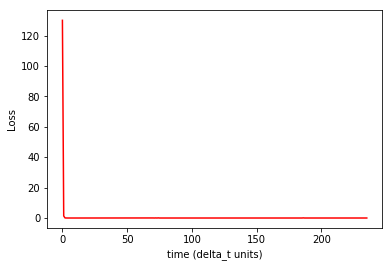

In [25]:
obs.plotLoss()

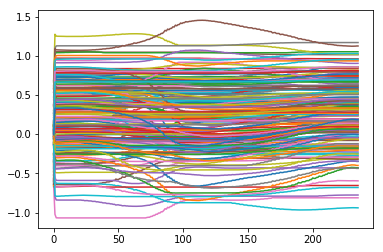

In [26]:
obs.plotParameters()

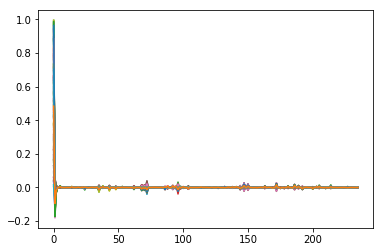

In [28]:
obs.plotVelocities()

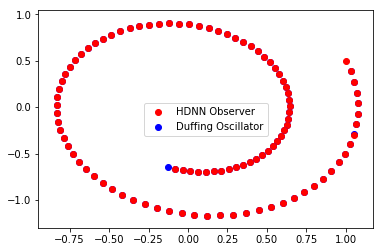

In [29]:
for p in range(len(t)-1):
    plt.scatter(t[p][0][0].cpu().numpy(),t[p][0][1].cpu().numpy(), color='r')
    plt.scatter(labels[p][0].cpu().numpy(),labels[p][1].cpu().numpy(), color='b')
    plt.legend(['HDNN Observer','Duffing Oscillator'])

In [14]:
obs.predictor(x0)

tensor([[-2.9060, -0.0562]], device='cuda:0', grad_fn=<LogSoftmaxBackward>)

# Learning a vectorial field

First, generate a dataset of trajectories from randomly sampled initial conditions

In [133]:
def generateTrajectory(duration, npoints, dynamics):
    osc = dynamics 
    t = torch.linspace(0, duration, npoints)
    xi0 = torch.Tensor(np.random.randint(-15, 15, 2)).to(device)
    func = osc.forward
    return odeint(func,xi0,t)

In [134]:
def generateDSet(n_trajectories, n_points, duration, dynamics):
    dset = []
    for n in range(n_trajectories):
        d = generateTrajectory(duration, n_points, dynamics) 
        dset.append(d)
    return dset

In [265]:
dynamics = duffingOscillator(2,0.5,0.5,0.2)
dset = generateDSet(1, 60, 5, dynamics)

Idea: learn some samples of state trajectories of the same dynamical system from random initial conditions. Try to extrapolate some kind of vectorial field

In [266]:
obs = HDNN_Observer([2,36,2],'MLP',[1,2,0], 1, None, False, 'cpu')
sols = []
for i, traj in enumerate(dset):
    x0 = traj[0].view(1,2).to(device)
    labels = traj[1:].to(device)
    sol = obs.observe(x0, labels, epoch=1, ode_t=2, ode_step=2, loss_record_interval=400)
    sols.append(sol)
    print("Currently learning trajectory number {}, initial conditions {}". format(i, x0))

odeint iter: 10 
odeint iter: 20 
odeint iter: 30 
odeint iter: 40 
odeint iter: 50 
odeint iter: 60 
odeint iter: 70 
odeint iter: 80 
odeint iter: 90 
odeint iter: 100 
odeint iter: 110 
odeint iter: 120 
odeint iter: 130 
odeint iter: 140 
odeint iter: 150 
odeint iter: 160 
odeint iter: 170 
odeint iter: 180 
odeint iter: 190 
odeint iter: 200 
odeint iter: 210 
odeint iter: 220 
odeint iter: 230 
odeint iter: 240 
odeint iter: 250 
odeint iter: 260 
odeint iter: 270 
odeint iter: 280 
odeint iter: 290 
odeint iter: 300 
odeint iter: 310 
odeint iter: 320 
odeint iter: 330 
odeint iter: 340 
odeint iter: 350 
odeint iter: 360 
odeint iter: 370 
odeint iter: 380 
odeint iter: 390 
odeint iter: 400 
odeint iter: 410 
odeint iter: 420 
odeint iter: 430 
odeint iter: 440 
odeint iter: 450 
odeint iter: 460 
odeint iter: 470 
odeint iter: 480 
odeint iter: 490 
odeint iter: 500 
odeint iter: 510 
odeint iter: 520 
odeint iter: 530 
odeint iter: 540 
odeint iter: 550 
odeint iter: 560 
o

odeint iter: 4400 
odeint iter: 4410 
odeint iter: 4420 
odeint iter: 4430 
odeint iter: 4440 
odeint iter: 4450 
odeint iter: 4460 
odeint iter: 4470 
odeint iter: 4480 
odeint iter: 4490 
odeint iter: 4500 
odeint iter: 4510 
odeint iter: 4520 
odeint iter: 4530 
odeint iter: 4540 
odeint iter: 4550 
odeint iter: 4560 
odeint iter: 4570 
odeint iter: 4580 
odeint iter: 4590 
odeint iter: 4600 
odeint iter: 4610 
odeint iter: 4620 
odeint iter: 4630 
odeint iter: 4640 
odeint iter: 4650 
odeint iter: 4660 
odeint iter: 4670 
odeint iter: 4680 
odeint iter: 4690 
odeint iter: 4700 
odeint iter: 4710 
odeint iter: 4720 
odeint iter: 4730 
odeint iter: 4740 
odeint iter: 4750 
odeint iter: 4760 
odeint iter: 4770 
odeint iter: 4780 
odeint iter: 4790 
odeint iter: 4800 
odeint iter: 4810 
odeint iter: 4820 
odeint iter: 4830 
odeint iter: 4840 
odeint iter: 4850 
odeint iter: 4860 
odeint iter: 4870 
odeint iter: 4880 
odeint iter: 4890 
odeint iter: 4900 
odeint iter: 4910 
odeint iter:

odeint iter: 8750 
odeint iter: 8760 
odeint iter: 8770 
odeint iter: 8780 
odeint iter: 8790 
odeint iter: 8800 
odeint iter: 8810 
odeint iter: 8820 
odeint iter: 8830 
odeint iter: 8840 
odeint iter: 8850 
odeint iter: 8860 
odeint iter: 8870 
odeint iter: 8880 
odeint iter: 8890 
odeint iter: 8900 
odeint iter: 8910 
odeint iter: 8920 
odeint iter: 8930 
odeint iter: 8940 
odeint iter: 8950 
odeint iter: 8960 
odeint iter: 8970 
odeint iter: 8980 
odeint iter: 8990 
odeint iter: 9000 
odeint iter: 9010 
odeint iter: 9020 
odeint iter: 9030 
odeint iter: 9040 
odeint iter: 9050 
odeint iter: 9060 
odeint iter: 9070 
odeint iter: 9080 
odeint iter: 9090 
odeint iter: 9100 
odeint iter: 9110 
odeint iter: 9120 
odeint iter: 9130 
odeint iter: 9140 
odeint iter: 9150 
odeint iter: 9160 
odeint iter: 9170 
odeint iter: 9180 
odeint iter: 9190 
odeint iter: 9200 
odeint iter: 9210 
odeint iter: 9220 
odeint iter: 9230 
odeint iter: 9240 
odeint iter: 9250 
odeint iter: 9260 
odeint iter:

odeint iter: 12900 
odeint iter: 12910 
odeint iter: 12920 
odeint iter: 12930 
odeint iter: 12940 
odeint iter: 12950 
odeint iter: 12960 
odeint iter: 12970 
odeint iter: 12980 
odeint iter: 12990 
odeint iter: 13000 
odeint iter: 13010 
odeint iter: 13020 
odeint iter: 13030 
odeint iter: 13040 
odeint iter: 13050 
odeint iter: 13060 
odeint iter: 13070 
odeint iter: 13080 
odeint iter: 13090 
odeint iter: 13100 
odeint iter: 13110 
odeint iter: 13120 
odeint iter: 13130 
odeint iter: 13140 
odeint iter: 13150 
odeint iter: 13160 
odeint iter: 13170 
odeint iter: 13180 
odeint iter: 13190 
odeint iter: 13200 
odeint iter: 13210 
odeint iter: 13220 
odeint iter: 13230 
odeint iter: 13240 
odeint iter: 13250 
odeint iter: 13260 
odeint iter: 13270 
odeint iter: 13280 
odeint iter: 13290 
odeint iter: 13300 
odeint iter: 13310 
odeint iter: 13320 
odeint iter: 13330 
odeint iter: 13340 
odeint iter: 13350 
odeint iter: 13360 
odeint iter: 13370 
odeint iter: 13380 
odeint iter: 13390 


odeint iter: 17000 
odeint iter: 17010 
odeint iter: 17020 
odeint iter: 17030 
odeint iter: 17040 
odeint iter: 17050 
odeint iter: 17060 
odeint iter: 17070 
odeint iter: 17080 
odeint iter: 17090 
odeint iter: 17100 
odeint iter: 17110 
odeint iter: 17120 
odeint iter: 17130 
odeint iter: 17140 
odeint iter: 17150 
odeint iter: 17160 
odeint iter: 17170 
odeint iter: 17180 
odeint iter: 17190 
odeint iter: 17200 
odeint iter: 17210 
odeint iter: 17220 
odeint iter: 17230 
odeint iter: 17240 
odeint iter: 17250 
odeint iter: 17260 
odeint iter: 17270 
odeint iter: 17280 
odeint iter: 17290 
odeint iter: 17300 
odeint iter: 17310 
odeint iter: 17320 
odeint iter: 17330 
odeint iter: 17340 
odeint iter: 17350 
odeint iter: 17360 
odeint iter: 17370 
odeint iter: 17380 
odeint iter: 17390 
odeint iter: 17400 
odeint iter: 17410 
odeint iter: 17420 
odeint iter: 17430 
odeint iter: 17440 
odeint iter: 17450 
odeint iter: 17460 
odeint iter: 17470 
odeint iter: 17480 
odeint iter: 17490 


# Vec field plot

In [267]:
def calculateComponents(x0, x1):
    return x1[0] - x0[0], x1[1] - x0[1]

In [276]:
mh = genpoints(-5, 5, -5, 5, 15)

In [277]:
obs.predictor(mh[0].view(1,2))

tensor([[-8.9726, -2.4374]], device='cuda:0', grad_fn=<AddmmBackward>)

In [278]:
U, V = [], []
for point in mh:
        un, vn = calculateComponents(point, obs.predictor(point.view(1,2)).flatten())
        U.append(un)
        V.append(vn)

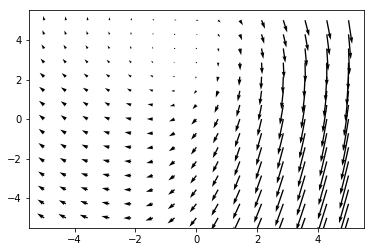

In [279]:
plt.quiver([p[0].detach().cpu() for p in mh], [p[1].detach().cpu() for p in mh], \
           [u.detach().cpu() for u in U], [v.detach().cpu() for v in V])

In [280]:
U, V = [], []
t = torch.linspace(0,1/25,2)
func = dynamics.forward
for point in mh:
        xi0 = point        
        sol = odeint(func, xi0, t)
        un, vn = calculateComponents(point, sol[-1])
        U.append(un)
        V.append(vn)

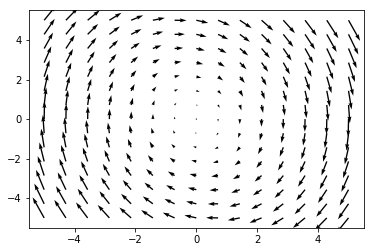

In [281]:
plt.quiver([p[0].detach().cpu() for p in mh], [p[1].detach().cpu() for p in mh], \
           [u.detach().cpu() for u in U], [v.detach().cpu() for v in V])

### Learned trajectories

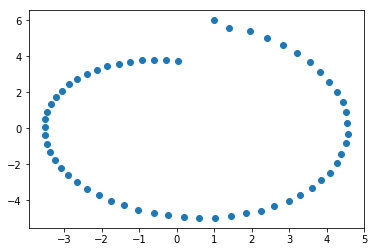

In [274]:
for sol in sols:
    plt.scatter(np.array([p.detach().cpu().flatten()[0] for p in sol]), \
                np.array([p.detach().cpu().flatten()[1] for p in sol]))

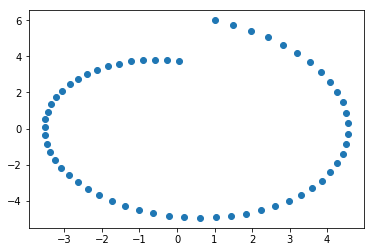

In [275]:
for sol in dset:
    plt.scatter(np.array([p.detach().cpu().flatten()[0] for p in sol]), \
                np.array([p.detach().cpu().flatten()[1] for p in sol]))